In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/7791.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/8401.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/5761.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/8451.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/5511.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/2721.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/2921.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/371.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/5671.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/5421.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/4061.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/4751.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/1891.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/7851.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blue

In [16]:
#!pip install imagecodecs

In [17]:
!pip install tensorflow tifffile opencv-python
import tifffile as tiff

In [18]:
import os
import numpy as np
import cv2
import tifffile as tiff
from tqdm import tqdm

# ==== CONFIG ====
DATA_DIR = "/kaggle/input/new-coffee-11/coffee_augmented"
LABELS = ["norust", "rust"]
IMAGE_SIZE = (224, 224)  # Resize image
BLUE_BAND_ID = 1  # Example ID for Blue band
BLUE_BAND_FOLDER = "blueband"  # ✅ Updated folder name

def load_blue_band_dataset():
    X, y = [], []

    for label_idx, label in enumerate(LABELS):
        band_path = os.path.join(DATA_DIR, BLUE_BAND_FOLDER, label)
        if not os.path.exists(band_path):
            raise FileNotFoundError(f"[ERROR] Folder not found: {band_path}")

        files = [f for f in os.listdir(band_path) if f.lower().endswith(".tif")]
        print(f"\n{label.upper()} — Found {len(files)} Blue band images")

        for f in tqdm(files, desc=f"Loading {label}"):
            try:
                img_path = os.path.join(band_path, f)
                img = tiff.imread(img_path)
                img = cv2.resize(img, IMAGE_SIZE)
                img = img.astype(np.float32).reshape(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)  # Add channel dimension

                X.append(img)
                y.append(label_idx)

            except Exception as e:
                print(f"[ERROR] Skipping file {f}: {e}")

    print(f"\n✅ Finished loading: {len(X)} Blue band images total.")
    return np.array(X, dtype=np.float32), np.array(y)

# === Load Dataset ===
X_blue, y_blue = load_blue_band_dataset()  # From your Blue band loader
print("✅ Final dataset shape:", X_blue.shape, y_blue.shape)  # Expecting: (num_images, 224, 224, 1), (num_images,)


NORUST — Found 819 Blue band images


Loading norust: 100%|██████████| 819/819 [00:01<00:00, 785.09it/s]



RUST — Found 848 Blue band images


Loading rust: 100%|██████████| 848/848 [00:01<00:00, 827.35it/s]



✅ Finished loading: 1667 Blue band images total.
✅ Final dataset shape: (1667, 224, 224, 1) (1667,)


In [19]:
import os
import numpy as np
import cv2
import tifffile as tiff
from tqdm import tqdm

# ==== CONFIG ====
DATA_DIR = "/kaggle/input/new-coffee-11/coffee_augmented"
LABELS = ["norust", "rust"]
IMAGE_SIZE = (224, 224)  # Resize image before index computation
SELECTED_BANDS = [2, 5]  # Green, NIR for GNDVI

BAND_FOLDERS = {
    0: "rgb",
    1: "blueband",
    2: "greenband",
    3: "redband",
    4: "rededgeband",
    5: "nir"
}

def compute_gndvi_image(green, nir):
    gndvi = (nir - green) / (nir + green + 1e-6)
    gndvi = np.clip(gndvi, -1, 1)
    return gndvi.reshape(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)

def load_gndvi_dataset():
    X, y = [], []

    for label_idx, label in enumerate(LABELS):
        band_files = {band_id: {} for band_id in SELECTED_BANDS}

        for band_id in SELECTED_BANDS:
            band_path = os.path.join(DATA_DIR, BAND_FOLDERS[band_id], label)
            if not os.path.exists(band_path):
                raise FileNotFoundError(f"[ERROR] Folder not found: {band_path}")

            for f in os.listdir(band_path):
                ext = f.lower().split('.')[-1]
                if ext != "tif":
                    continue
                try:
                    base = int(f.split('.')[0])
                    band_files[band_id][base] = os.path.join(band_path, f)
                except:
                    print(f"[WARN] Skipping unreadable filename: {f}")

        # Match samples across bands
        common_bases = set(k - (k % 10) for k in band_files[SELECTED_BANDS[0]].keys())
        for band_id in SELECTED_BANDS[1:]:
            common_bases &= set(k - (k % 10) for k in band_files[band_id].keys())

        print(f"\n{label.upper()} — Found {len(common_bases)} complete sample sets")

        for base in tqdm(sorted(common_bases), desc=f"Loading {label}"):
            try:
                band_images = {}
                for band_id in SELECTED_BANDS:
                    file_id = base + band_id
                    file_path = band_files[band_id].get(file_id, None)
                    if file_path is None:
                        raise FileNotFoundError(f"[MISSING] {file_id} in band {BAND_FOLDERS[band_id]}")

                    img = tiff.imread(file_path)
                    img = cv2.resize(img, IMAGE_SIZE)
                    band_images[band_id] = img.astype(np.float32)

                green = band_images[2]
                nir = band_images[5]

                gndvi_img = compute_gndvi_image(green, nir)
                X.append(gndvi_img)
                y.append(label_idx)

            except Exception as e:
                print(f"[ERROR] Skipping sample base {base}: {e}")

    print(f"\n✅ Finished loading: {len(X)} GNDVI images total.")
    return np.array(X, dtype=np.float32), np.array(y)

# === Load GNDVI Dataset ===
X_gndvi, y_gndvi = load_gndvi_dataset()
print("✅ Final GNDVI dataset shape:", X_gndvi.shape, y_gndvi.shape)


NORUST — Found 819 complete sample sets


Loading norust: 100%|██████████| 819/819 [00:02<00:00, 391.56it/s]



RUST — Found 848 complete sample sets


Loading rust: 100%|██████████| 848/848 [00:02<00:00, 405.75it/s]



✅ Finished loading: 1667 GNDVI images total.
✅ Final GNDVI dataset shape: (1667, 224, 224, 1) (1667,)


In [20]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [21]:
assert len(X_blue) == len(X_gndvi) == len(y_blue) == len(y_gndvi), "Mismatch in dataset lengths"
assert np.array_equal(y_blue, y_gndvi), "Label mismatch"

In [22]:
y = y_blue

In [23]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np

# Normalize inputs
X_blue = X_blue / 255.0
X_gndvi = X_gndvi / 1.0  # Already in [-1, 1]

# Convert labels to categorical
y_cat = to_categorical(y, num_classes=2)

# Step 1: Split into 80% train+val, 20% test
Xr_temp, Xr_test, Xn_temp, Xn_test, y_temp, y_test = train_test_split(
    X_blue, X_gndvi, y_cat, test_size=0.2, random_state=42, stratify=y
)

# Step 2: Split 80% part into 70% train, 10% val
# 10 / 80 = 0.125 → 12.5% of train_val becomes validation
Xr_train, Xr_val, Xn_train, Xn_val, y_train, y_val = train_test_split(
    Xr_temp, Xn_temp, y_temp, test_size=0.125, random_state=42, stratify=np.argmax(y_temp, axis=1)
)


In [24]:
print("🔴 BLUE Band Shapes:")
print("Train:", Xr_train.shape)
print("Val:  ", Xr_val.shape)
print("Test: ", Xr_test.shape)

print("\n🌿 GNDVI Shapes:")
print("Train:", Xn_train.shape)
print("Val:  ", Xn_val.shape)
print("Test: ", Xn_test.shape)

print("\n🏷️ Label Shapes:")
print("Train:", y_train.shape)
print("Val:  ", y_val.shape)
print("Test: ", y_test.shape)

🔴 BLUE Band Shapes:
Train: (1166, 224, 224, 1)
Val:   (167, 224, 224, 1)
Test:  (334, 224, 224, 1)

🌿 GNDVI Shapes:
Train: (1166, 224, 224, 1)
Val:   (167, 224, 224, 1)
Test:  (334, 224, 224, 1)

🏷️ Label Shapes:
Train: (1166, 2)
Val:   (167, 2)
Test:  (334, 2)


In [25]:
def build_blue_branch(input_shape):
    input_blue = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu')(input_blue)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.8)(x)
    return input_blue, x

# === Define CNN model for NDVI ===
def build_gndvi_branch(input_shape):
    input_gndvi = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu')(input_gndvi)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.8)(x)
    return input_gndvi, x

# === Combine branches ===
input_blue, blue_branch = build_blue_branch((224, 224, 1))
input_gndvi, gndvi_branch = build_gndvi_branch((224, 224, 1))

merged = Concatenate()([blue_branch, gndvi_branch])
x = Dense(256, activation='relu')(merged)
x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)

# Final model
model = Model(inputs=[input_blue, input_gndvi], outputs=output)

In [26]:
from tensorflow.keras.optimizers import Adam
# Set custom learning rate
lr = 0.00005  # example value

optimizer = Adam(learning_rate=lr)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 222, 222,  │        640 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 222, 222,  │        640 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 111, 111,  │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 111, 111,  │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 109, 109,  │     18,464 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 109, 109,  │     18,464 │ max_pooling2d_6[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 54, 54,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 54, 54,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 93312)     │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 93312)     │          0 │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │ 11,944,064 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │ 11,944,064 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256)       │          0 │ dropout_3[0][0],  │
│ (Concatenate)       │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │     65,792 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 256)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 23,992,642 (91.52 MB)

 Trainable params: 23,992,642 (91.52 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
history = model.fit(
    [Xr_train, Xn_train], y_train,
    validation_data=([Xr_val, Xn_val], y_val),
    epochs=20,
    batch_size=64
)

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 342ms/step - accuracy: 0.5236 - loss: 0.8240 - val_accuracy: 0.8263 - val_loss: 0.5468
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - accuracy: 0.6657 - loss: 0.6188 - val_accuracy: 0.8204 - val_loss: 0.4982
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - accuracy: 0.7140 - loss: 0.5714 - val_accuracy: 0.8263 - val_loss: 0.4638
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - accuracy: 0.7665 - loss: 0.5564 - val_accuracy: 0.8263 - val_loss: 0.4503
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.7593 - loss: 0.4938 - val_accuracy: 0.8263 - val_loss: 0.4403
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - accuracy: 0.7642 - loss: 0.5100 - val_accuracy: 0.8323 - val_loss: 0.4307
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.7812 - loss: 0.4698 - val_accuracy: 0.8323 - val_loss: 0.4227
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.7657 - loss: 0.5094 - val_accuracy: 0

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step

--- Train Set Metrics ---
Accuracy : 0.8293
Precision: 0.7641
Recall   : 0.9612
F1 Score : 0.8514
ROC AUC  : 0.9085

Classification Report:
              precision    recall  f1-score   support

      norust       0.95      0.69      0.80       573
        rust       0.76      0.96      0.85       593

    accuracy                           0.83      1166
   macro avg       0.85      0.83      0.83      1166
weighted avg       0.85      0.83      0.83      1166



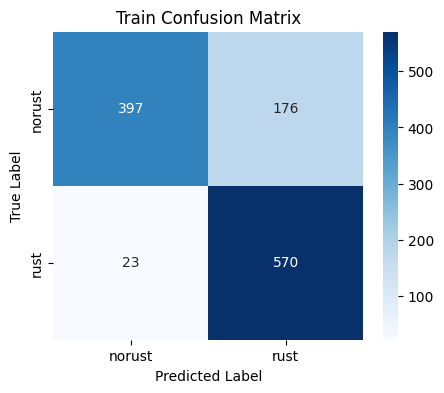

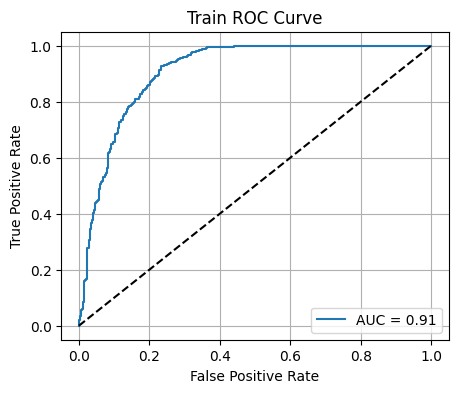

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

--- Test Set Metrics ---
Accuracy : 0.8234
Precision: 0.7630
Recall   : 0.9471
F1 Score : 0.8451
ROC AUC  : 0.8788

Classification Report:
              precision    recall  f1-score   support

      norust       0.93      0.70      0.79       164
        rust       0.76      0.95      0.85       170

    accuracy                           0.82       334
   macro avg       0.84      0.82      0.82       334
weighted avg       0.84      0.82      0.82       334



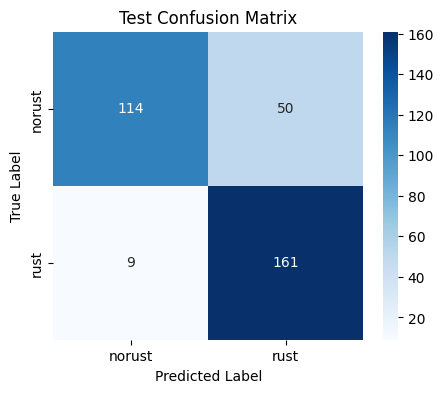

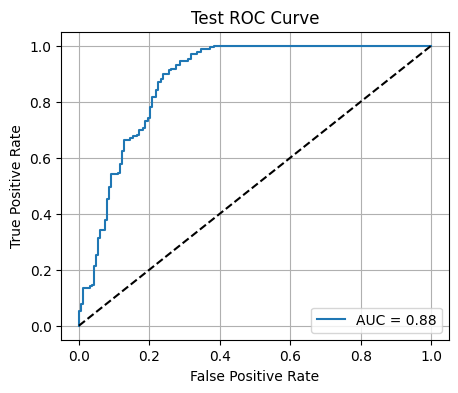

In [28]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_model(model, X_blue, X_gndvi, y_true, set_name="Set"):
    # Predict probabilities
    y_pred_prob = model.predict([X_blue, X_gndvi])

    # If y_true is one-hot encoded, convert to class index
    if y_true.ndim == 2 and y_true.shape[1] == 2:
        y_true = np.argmax(y_true, axis=1)

    y_pred = np.argmax(y_pred_prob, axis=1)

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_prob[:, 1])

    # Print metrics
    print(f"\n--- {set_name} Set Metrics ---")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"ROC AUC  : {auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=["norust", "rust"]))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["norust", "rust"],
                yticklabels=["norust", "rust"])
    plt.title(f"{set_name} Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{set_name} ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

# ✅ Example usage:
evaluate_model(model, Xr_train, Xn_train, y_train, set_name="Train")
evaluate_model(model, Xr_test, Xn_test, y_test, set_name="Test")